Import data from Data Cleaning output

In [419]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [420]:
df = pd.read_csv("C:/Users/Owner/Desktop/AlaskaProject/Data/modeldata.csv")
df.columns

Index(['participant.code', 'question', 'choice_binary', 'rowA_', 'rowB_',
       'price_diff', 'price_diff_rel', 'legroom_diff', 'bathroom_dist_diff',
       'distance_', 'price_', 'colA_categorical_Aisle',
       'colA_categorical_Middle', 'colA_categorical_Window',
       'colB_categorical_Aisle', 'colB_categorical_Middle',
       'colB_categorical_Window', 'seatA_class_Economy', 'seatA_class_First',
       'seatA_class_Premium', 'seatB_class_Economy', 'seatB_class_First',
       'seatB_class_Premium', 'plane_sideA_Left', 'plane_sideA_Right',
       'plane_sideB_Left', 'plane_sideB_Right', 'time__Daytime',
       'time__Red-eye', 'flyerfreq_nonflyer', 'flyerfreq_typical',
       'flyerfreq_frequent', 'flyertype_leisure', 'flyertype_business'],
      dtype='object')

In [421]:
df.drop(['participant.code','question'],inplace = True, axis = 1)
df.rename(columns={'time__Red-eye':'time_redeye'}, inplace=True)

    Define variables and train/test split

In [422]:
df_train = df.sample(frac = 0.8)
df_test = df.drop(df_train.index)

Scale continuous variables

In [423]:
# Scaled Variables
#Legroom
df_train["legroom_diff"] = preprocessing.scale(pd.to_numeric(df_train["legroom_diff"]))
df_test["legroom_diff"] = preprocessing.scale(pd.to_numeric(df_test["legroom_diff"]))

#Variable Price
df_train["price_diff"] = preprocessing.scale(pd.to_numeric(df_train["price_diff"]))
df_test["price_diff"] = preprocessing.scale(pd.to_numeric(df_test["price_diff"]))

#Distance
df_train["distance"] = preprocessing.scale(df_train["distance_"])
df_test["distance"] = preprocessing.scale(df_test["distance_"])


In [424]:
# Define output variable
y_dftrain = df_train.choice_binary
# Drop output variable from dataset to form input vector
X_dftrain = df_train.drop('choice_binary', axis=1)

# Define output variable
y_dftest = df_test.choice_binary
# Drop output variable from dataset to form input vector
X_dftest = df_test.drop('choice_binary', axis=1)



Create Basic Logistic Regression with no interaction terms

In [425]:
import statsmodels.api as sm
logitmodel=sm.Logit(y_dftrain,X_dftrain)
logresult=logitmodel.fit()
print(logresult.summary2())

         Current function value: 0.507537
         Iterations: 35
                                    Results: Logit
Model:                      Logit                   Pseudo R-squared:        0.264    
Dependent Variable:         choice_binary           AIC:                     4906.1709
Date:                       2021-05-22 15:21        BIC:                     5055.0699
No. Observations:           4788                    Log-Likelihood:          -2430.1  
Df Model:                   22                      LL-Null:                 -3303.1  
Df Residuals:               4765                    LLR p-value:             0.0000   
Converged:                  0.0000                  Scale:                   1.0000   
No. Iterations:             35.0000                                                   
--------------------------------------------------------------------------------------
                         Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
-------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [553]:
import statsmodels.formula.api  as smf


logit_inter=smf.logit("""
                    choice_binary ~ 
                    +rowA_
                    +rowB_ 
                    +price_diff 
                    +legroom_diff * distance 
                    
                    -distance
                    +price_diff_rel 
                                        
                    +colA_categorical_Middle : colB_categorical_Aisle 
                    +colA_categorical_Middle: colB_categorical_Window
                    +colA_categorical_Window : colB_categorical_Middle

                    +plane_sideA_Left : plane_sideB_Right
                    
                    +colA_categorical_Aisle : time_redeye
                    +colA_categorical_Window : time_redeye
                    
                    +price_diff : flyerfreq_frequent
                    +price_diff : flyertype_business

                

                    """, data = df_train)
                    

logresult2=logit_inter.fit( maxiter = 500)

print(logresult2.summary2())

Optimization terminated successfully.
         Current function value: 0.519517
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.247    
Dependent Variable:             choice_binary              AIC:                        5004.8943
Date:                           2021-05-22 16:15           BIC:                        5102.0024
No. Observations:               4788                       Log-Likelihood:             -2487.4  
Df Model:                       14                         LL-Null:                    -3303.1  
Df Residuals:                   4773                       LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [554]:
feature_names = logresult2.params.index
coefficients = logresult2.params.values

coefs = pd.DataFrame({
    'coef': coefficients,
    'odds ratio': np.exp(logresult2.params.values),
    'pvalue': logresult2.pvalues,
}).sort_values(by='odds ratio', ascending=False)
coefs

,coef,odds ratio,pvalue
colA_categorical_Window:colB_categorical_Middle,2.44764,11.56102,0.00000
Intercept,0.54929,1.73203,0.00000
price_diff:flyertype_business,0.22176,1.24827,0.03544
price_diff:flyerfreq_frequent,0.17951,1.19664,0.04886
legroom_diff:distance,0.12104,1.12867,0.00626
rowB_,0.05252,1.05393,0.00000
rowA_,-0.10215,0.90290,0.00000
legroom_diff,-0.14211,0.86753,0.01175
colA_categorical_Window:time_redeye,-0.17884,0.83624,0.04060
price_diff,-0.76167,0.46688,0.00000


Check the Confusion Matrix

In [555]:
predicted_output = logresult2.predict(df_test)
predicted_output

0      0.63413
6      0.24528
7      0.40314
20     0.96850
21     0.71038
         ...  
5966   0.59338
5968   0.46153
5977   0.37195
5979   0.30343
5984   0.96796
Length: 1197, dtype: float64

<AxesSubplot:>

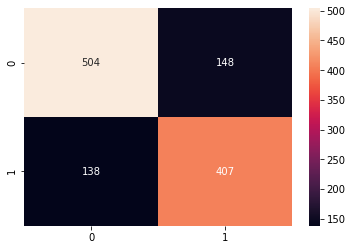

In [556]:
pred = np.array(logresult2.predict(df_test) > 0.5, dtype=float)
confmatrix = np.histogram2d(y_dftest, pred, bins=2)[0]
sns.heatmap(confmatrix, annot = True, fmt='g')

In [557]:
TN = confmatrix[0,0]
TP = confmatrix[1,1]
FN = confmatrix[1,0]
FP = confmatrix[0,1]

correct = TN+TP
incorrect = FN+FP

accuracy = correct/(correct+incorrect)
accuracy

0.7610693400167085